# 模型检测
使用刚刚训练好的模型来进行检测

In [1]:
# 设置使用GPU运行
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")

print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


此处同样使用tf.keras.preprocessing.image_dataset_from_directory从测试集导入数据，不需要进行进一步划分，在Train&Save.ipynb里的参数validation_split(验证集比例)、subset(数据集类型)和seed(随机划分种子)均不必再设置

In [2]:
img_height = 200
img_width  = 150
batch_size = 9

"""
设置测试集
"""
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./TestDataSet/",
    label_mode = "categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)
class_names = test_ds.class_names
print(class_names)

Found 3326 files belonging to 3 classes.
['cloud', 'cloudy', 'sun']


In [3]:
# 导入预先训练好的模型
from  tensorflow.keras.models import load_model
Des_classifier=load_model("my_model_DesNet.h5")
Res_classifier=load_model("my_model_ResNet.h5")

In [4]:
# 测试一下准确率
from PIL import Image
import os
import numpy as np
test_dir = "./TestDataSet/"
test_dirs = os.listdir(test_dir)

i,j,k = 0, 0, 0
for images, labels in test_ds:
    for img, label in zip(images, labels):
        i = i+1
        if i%300 == 0 :
            print("已检测%.2f"%(i/33.26),"%的数据")
        image = tf.image.resize(img, [img_height, img_width])/255.0
        # 测试前需要给图片增加一个维度
        img_array = tf.expand_dims(image, 0) 
        
        prediction1 = Des_classifier.predict(img_array)
        prediction2 = Res_classifier.predict(img_array)
        if class_names[np.argmax(prediction1)] == class_names[np.argmax(label)]:
            j=j+1
        if class_names[np.argmax(prediction2)] == class_names[np.argmax(label)]:
            k=k+1

print("共",i,"张测试图，DenseNet正确识别",j,"张，RenseNet正确识别",k,"张")
print("DenseNet正确率: %.2f"%(j/i*100),"%    ","RenseNet正确率:%.2f"%(k/i*100),"%")

已检测9.02 %的数据
已检测18.04 %的数据
已检测27.06 %的数据
已检测36.08 %的数据
已检测45.10 %的数据
已检测54.12 %的数据
已检测63.14 %的数据
已检测72.16 %的数据
已检测81.18 %的数据
已检测90.20 %的数据
已检测99.22 %的数据
共 3326 张测试图，DenseNet正确识别 3292 张，RenseNet正确识别 3299 张
DenseNet正确率: 98.98 %     RenseNet正确率:99.19 %


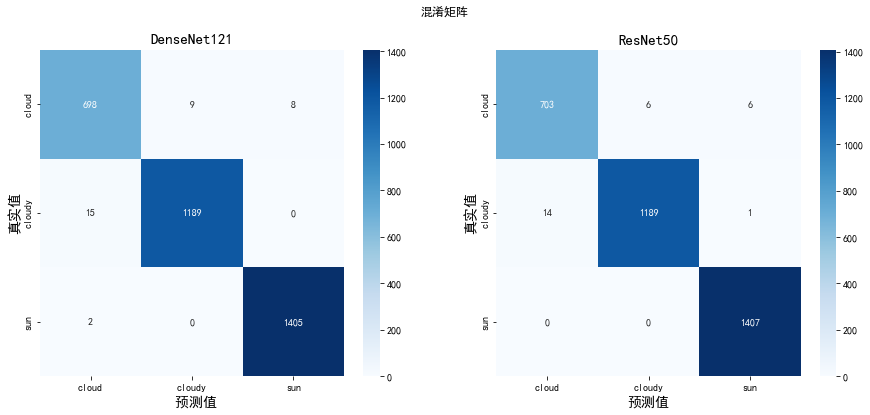

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 定义一个绘制混淆矩阵图的函数
def plot_cm(labels1, predictions1,labels2, predictions2):
    
    # 生成混淆矩阵
    conf_numpy1 = confusion_matrix(labels1, predictions1)
    conf_numpy2 = confusion_matrix(labels2, predictions2)
    # 将矩阵转化为 DataFrame
    conf_df1 = pd.DataFrame(conf_numpy1, index=class_names ,columns=class_names)  
    conf_df2 = pd.DataFrame(conf_numpy2, index=class_names ,columns=class_names)  
    
    plt.figure(figsize=(15,6))
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.subplot(1,2,1)
    sns.heatmap(conf_df1, annot=True, fmt="d", cmap="Blues")
    plt.suptitle('混淆矩阵')
    
    plt.title('DenseNet121',fontsize=15)
    plt.ylabel('真实值',fontsize=14)
    plt.xlabel(' 预测值',fontsize=14)
    plt.subplot(1,2,2)
    sns.heatmap(conf_df2, annot=True, fmt="d", cmap="Blues")
    
    plt.title('ResNet50',fontsize=15)
    plt.ylabel('真实值',fontsize=14)
    plt.xlabel('预测值',fontsize=14)

val_pre1   = []
val_label1 = []
val_pre2   = []
val_label2 = []

for images, labels in test_ds:#这里可以取部分验证数据（.take(1)）生成混淆矩阵
    for img, label in zip(images, labels):
        image = tf.image.resize(img, [img_height, img_width])/255.0
        # 测试前需要给图片增加一个维度
        img_array = tf.expand_dims(image, 0) 
        
        prediction1 = Des_classifier.predict(img_array)
        prediction2 = Res_classifier.predict(img_array)

        val_pre1.append(np.argmax(prediction1))
        val_label1.append([np.argmax(one_hot)for one_hot in [label]])
        val_pre2.append(np.argmax(prediction2))
        val_label2.append([np.argmax(one_hot)for one_hot in [label]])
plot_cm(val_label1, val_pre1,val_label2, val_pre2)